## What is LibROSA? ##

Librosa is a Python package for music information retrieval (MIR). There has recently been a confluence of several factors that have led to its developement, including increasing demand from musicologists and theorists for a comprehensive music packages, and also AI packages in Python like [Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn).

The entire codebase is opensource on [Github](https://github.com/librosa/librosa).

There are different broad modules that focus on different tasks, and the authors of the library have paid particuarly close attention to the readability and usability of the code for beginners and advanced researchers. In particular, many parameters are initialized for us, but experienced users can modify it. In particular, some of the main modules are:

#### Core ####

Four categories exist under the .core module:

1. audio and time series
2. spectogram calculation
3. time and frequency conversion
4. pitch operations

Of particular interest to this tutorial, Librosa offers a number of Spectrogram operations including the short-time Fourier transform  (stft), inverse STFT (istft), and instantaneous  frequency spectrogram (ifgram).

An efficient constant-Q transform (cqt) implementa-tion based upon the "recursive down-sampling method of Scherkhuber and Klapuri" is provided, which produces "logarithmically spaced frequency representations  suitablefor pitch-based signal analysis.".

It is worth noting that it also offers different time representations: seconds,frames, or samples; and frequency representations: hertz, constant-Q  basis  index,  Fourier  basis  index,  Mel  basis  index,  MIDI  notenumber, or note in scientific pitch notation.

#### Producing a Spectogram ####

Let's produce a STFT of an arbitrary clip - say the wav file of Mravalzhamier.

First I estimate the tempo

Y is a time series, represented as a one-dimensional NumPy floating point array. The variable 'sr' contains the sampling rate of y, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to librosa.load().

In [28]:
#example of detecting the bpm of a musical package

import librosa
import numpy as np
import matplotlib.pyplot as plt

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav')

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 123.05 beats per minute


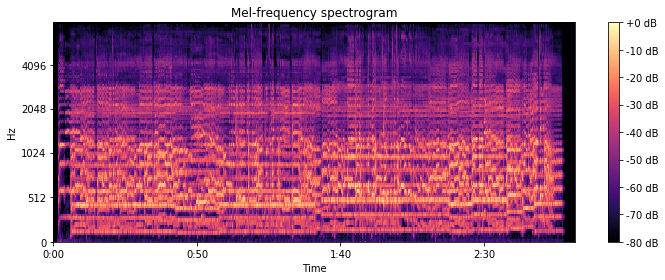

In [17]:
# display arbitrary melspectogram

import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

librosa.feature.melspectrogram(y=y, sr=sr)

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

Evidentally it's possible to use agglomeritive clustering to segment the specogram.  Let's produce the spectogram of the file we're interested in:

/usr/local/lib/python3.5/dist-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


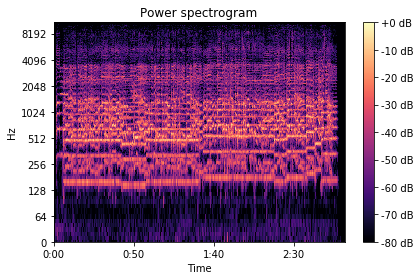

In [21]:
# can we producea specogram of part of the table song?

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# load the file
y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav')

# D is a numpy array that represents the short time fourier transform

D = librosa.stft(y)

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Obviously it's not useful to display the entire spectogram because we lose so much information, but we can analyze the spectogram within a specific time interval (a,b) for closer analysis. Let's do that.

https://librosa.github.io/librosa/generated/librosa.segment.subsegment.html

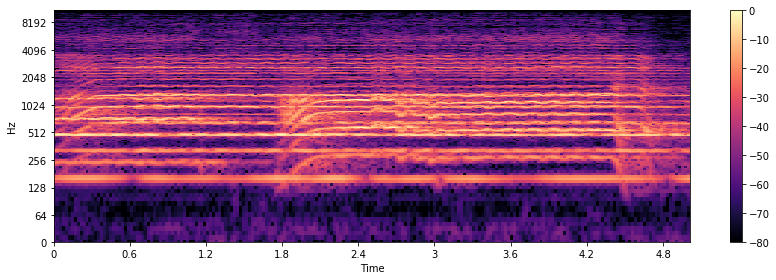

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# load the file
# y is the time series, represented as a numpy array
# sr is the sample rate

y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', duration = 60)

# compute the magnitude and phase

S_full, phase = librosa.magphase(librosa.stft(y))

# five second slice of the song

idx = slice(*librosa.time_to_frames([30, 35], sr=sr))

# plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

Seperate into foreground and background

/usr/local/lib/python3.5/dist-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.5/dist-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


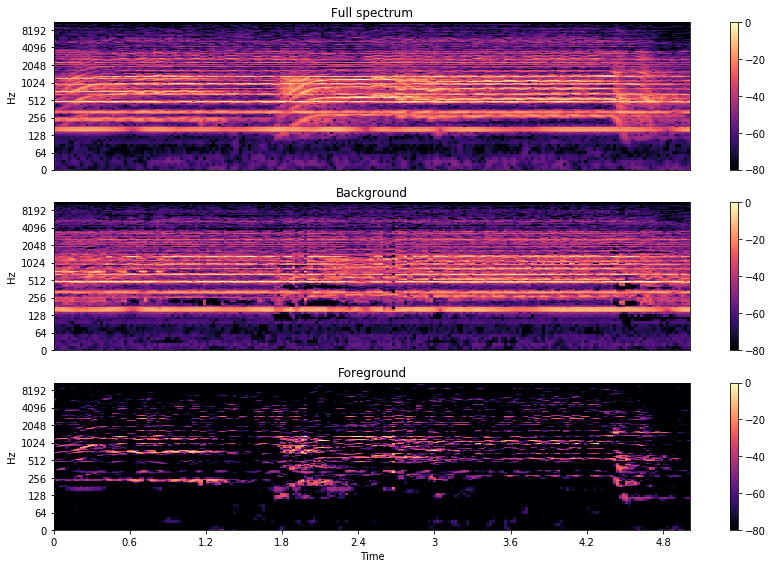

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# load the file
# y is the time series, represented as a numpy array
# sr is the sample rate

y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', duration = 60)

# compute the magnitude and phase

S_full, phase = librosa.magphase(librosa.stft(y))

# five second slice of the song

idx = slice(*librosa.time_to_frames([30, 35], sr=sr))

# compare frames using cosine similarity and also aggregate similar frames
# by taking their (per-frequency) median value.

S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr)))

# make sure output isn't greater than input

S_filter = np.minimum(S_full, S_filter)

margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)

mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

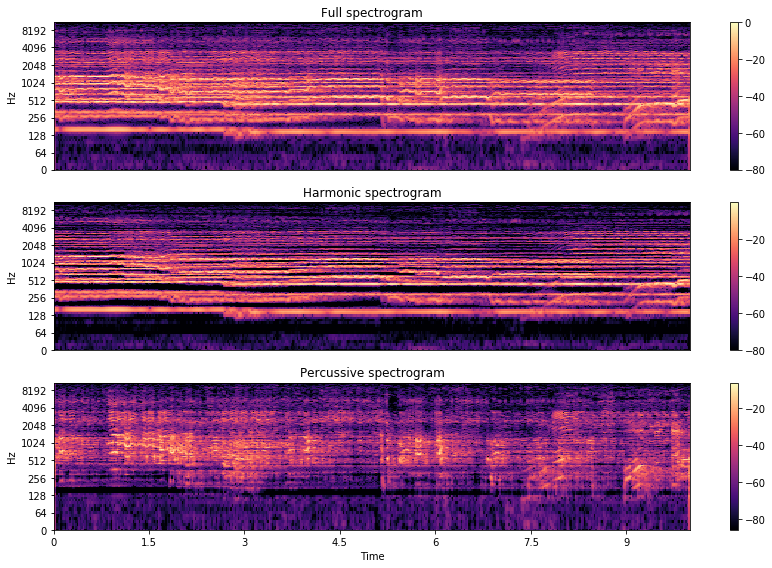

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display


y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', offset=40, duration=10)

D = librosa.stft(y)

# decompose into harmonic and percussive elements

D_harmonic, D_percussive = librosa.decompose.hpss(D)

# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

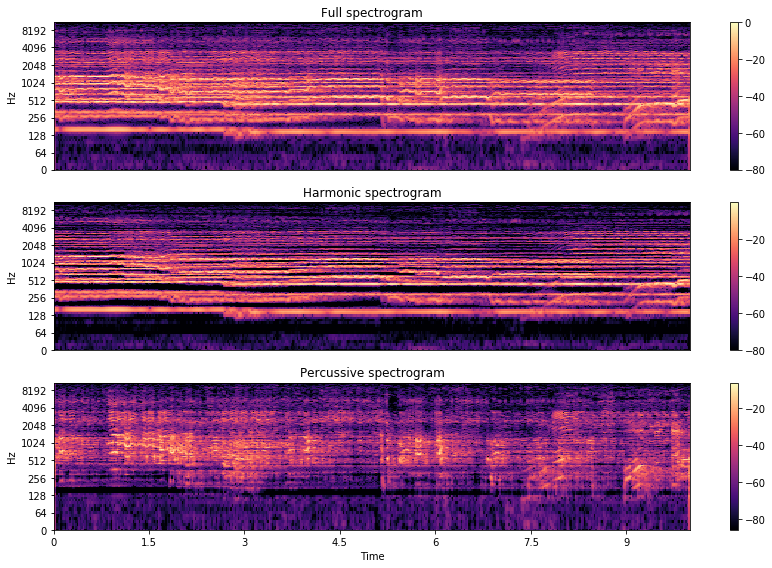

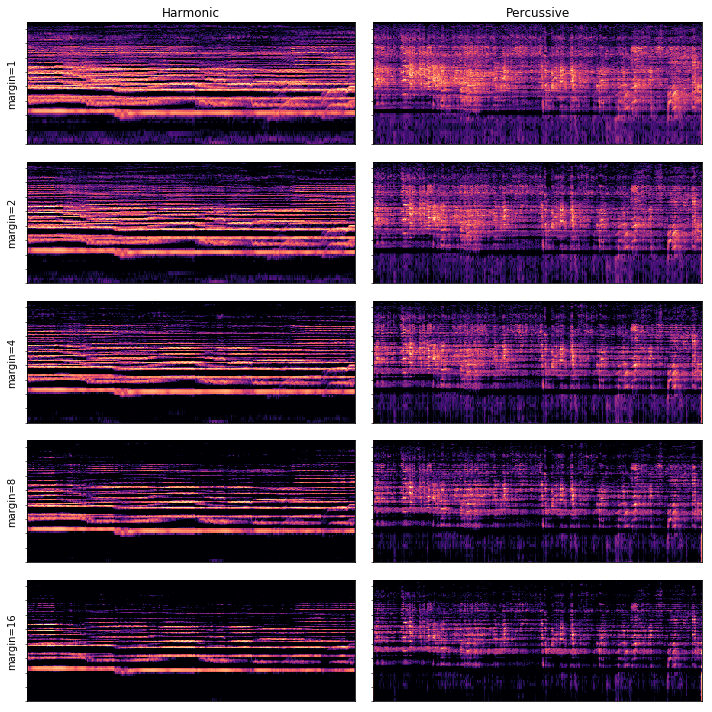

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display


y, sr = librosa.load('01 Mravalzhamier - Table Song, Kakheti.wav', offset=40, duration=10)

D = librosa.stft(y)

# decompose into harmonic and percussive elements

D_harmonic, D_percussive = librosa.decompose.hpss(D)

# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

# # Let's compute separations for a few different margins and compare the results below

D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

plt.figure(figsize=(10, 10))

plt.subplot(5, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.title('Harmonic')
plt.yticks([])
plt.ylabel('margin=1')

plt.subplot(5, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log')
plt.title('Percussive')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic2), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=2')

plt.subplot(5, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive2), ref=rp), y_axis='log')
plt.yticks([]) ,plt.ylabel('')

plt.subplot(5, 2, 5)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic4), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=4')

plt.subplot(5, 2, 6)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive4), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 7)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic8), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=8')

plt.subplot(5, 2, 8)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive8), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.subplot(5, 2, 9)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp), y_axis='log')
plt.yticks([])
plt.ylabel('margin=16')

plt.subplot(5, 2, 10)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp), y_axis='log')
plt.yticks([]), plt.ylabel('')

plt.tight_layout()
plt.show()